In [ ]:
# 初回のみ実行
!mkdir data
!wget -P data https://www.info-proto.com/static/jageocoder/latest/v2/jukyo_all_v21.zip
!rye run jageocoder install-dictionary jukyo_all_v21.zip

In [16]:
import requests
from bs4 import BeautifulSoup
from retry import retry
import urllib
import time
import numpy as np
import polars as pl
from tqdm import tqdm

make_df=True #Trueにすればデータが作成されます。一度実行した後はdataフォルダに作成したデータが保存されるのでFalseにしても大丈夫です。

# 複数ページの情報をまとめて取得
data_samples = []

# スクレイピングするページ数
max_page = 891 #891
# SUUMOから函館の家賃情報を取得します。
url = 'https://suumo.jp/jj/common/ichiran/JJ901FC004/?initFlg=1&seniFlg=1&pc=30&ar=010&ta=01&scTmp=01202&kb=0&xb=0&newflg=0&km=1&sc=01202&bs=040&pn={}'

# リクエストがうまく行かないパターンを回避するためのやり直し
@retry(tries=3)
def load_page(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser')
    return soup

def make_suumo_df():
    cats = []
    names = []
    address = []
    prices = []
    # ページごとの処理
    for page in tqdm(range(1,max_page+1)):
        before = time.time()
        # ページ情報
        soup = load_page(url.format(page))
        # 物件情報リストを指定
        mother = soup.find_all(class_='cassette js-bukkenCassette')
        # 物件ごとの処理
        for child in mother:

            # 建物情報
            # カテゴリ
            cats.append(child.find(class_='ui-pct ui-pct--util1 cassettebox-hpct cassettebox-hpctcat').text)
            # 建物名
            names.append(child.find(class_='js-cassetLinkHref').text)
            # 住所
            address.append(child.find(class_='infodatabox-box-txt').text.strip())
            # 家賃
            prices.append(np.float64(child.find(class_='infodatabox-details-txt').text.replace('万円', '')))


    df = pl.DataFrame({
        'name':names,
        'cat':cats,
        'address':address,
        'price':prices,
    })


    return df


In [17]:
df:pl.DataFrame
if make_df:
    df = make_suumo_df()
    df.write_parquet('data/suumo.parquet')
    print('データ作成完了')
else:
    df = pl.read_parquet('data/suumo.parquet')
    print('データ読み込み完了')

データ読み込み完了


In [18]:
# 前処理
import jageocoder
jageocoder.init()
df=df.group_by(["address",'name']).median()#アパートの部屋の家賃の中央値
df=df.group_by(["address"]).mean()#町ごとの平均
df=df.drop(['name','cat'])

price=df['price']
price_min = price.mean() - 2*np.sqrt(price.var())
price_max = price.mean() + 2*np.sqrt(price.var())
df=df.with_columns(
    cutted_price=price.clip(price_min,price_max),
    exped_price=np.exp(df['price']),
    x=df['address'].map_elements(lambda x:jageocoder.search(x)['candidates'][0]['x']),
    y=df['address'].map_elements(lambda x:jageocoder.search(x)['candidates'][0]['y']),
)


In [19]:
df.head()

address,price,cutted_price,exped_price,x,y
str,f64,f64,f64,f64,f64
"""北海道函館市杉並町""",5.85,5.85,347.23438,140.757187,41.788494
"""北海道函館市宝来町""",4.58,4.58,97.514394,140.721191,41.760105
"""北海道函館市日吉町４""",3.780952,3.780952,43.857791,140.793091,41.803566
"""北海道函館市湯浜町""",4.613158,4.613158,100.80197,140.775543,41.777218
"""北海道函館市湯川町２""",4.467442,4.467442,87.133538,140.788818,41.780521


In [40]:
# polarsのdfでpriceが最小な行を取得
min_price_row = df.filter(df['price']==df['price'].min())
min_price= min_price_row['price'][0]
min_price_address= min_price_row['address'][0]
print(f'エリアの最安値:{min_price}万円')
print(f'エリアの最安値の住所:{min_price_address}')
max_price_row = df.filter(df['price']==df['price'].max())
max_price= max_price_row['price'][0]
max_price_address= max_price_row['address'][0]
print(f'エリアの最高値:{max_price}万円')
print(f'エリアの最高値の住所:{max_price_address}')


エリアの最安値:1.55万円
エリアの最安値の住所:北海道函館市西旭岡町３
エリアの最高値:7.9万円
エリアの最高値の住所:北海道函館市女那川町


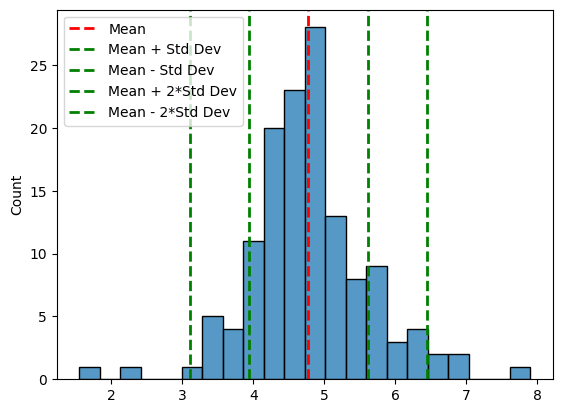

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

#外れ値込みの家賃のヒストグラム
sns.histplot(data=df['price'])
mean_value=df['price'].to_numpy().mean()
variance=df['price'].to_numpy().var()
# 平均を表す縦棒を描画
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')

# 標準偏差+平均を表す縦棒を描画
plt.axvline(mean_value + np.sqrt(variance), color='green', linestyle='dashed', linewidth=2, label='Mean + Std Dev')
plt.axvline(mean_value - np.sqrt(variance), color='green', linestyle='dashed', linewidth=2, label='Mean - Std Dev')
plt.axvline(mean_value + 2*np.sqrt(variance), color='green', linestyle='dashed', linewidth=2, label='Mean + 2*Std Dev')
plt.axvline(mean_value - 2*np.sqrt(variance), color='green', linestyle='dashed', linewidth=2, label='Mean - 2*Std Dev')
plt.legend()
plt.show()

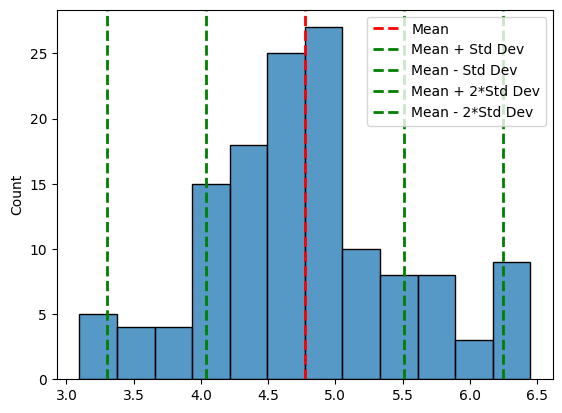

In [22]:
#外れ値を丸め込んだ可視化
sns.histplot(data=df['cutted_price'])
mean_value=df['cutted_price'].to_numpy().mean()
variance=df['cutted_price'].to_numpy().var()
# 平均を表す縦棒を描画
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')

# 標準偏差+平均を表す縦棒を描画
plt.axvline(mean_value + np.sqrt(variance), color='green', linestyle='dashed', linewidth=2, label='Mean + Std Dev')
plt.axvline(mean_value - np.sqrt(variance), color='green', linestyle='dashed', linewidth=2, label='Mean - Std Dev')
plt.axvline(mean_value + 2*np.sqrt(variance), color='green', linestyle='dashed', linewidth=2, label='Mean + 2*Std Dev')
plt.axvline(mean_value - 2*np.sqrt(variance), color='green', linestyle='dashed', linewidth=2, label='Mean - 2*Std Dev')
plt.legend()
plt.show()

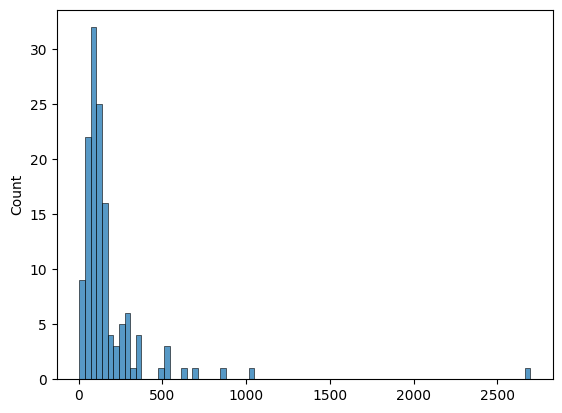

In [23]:
#expを利用して家賃の差を強調する
sns.histplot(data=np.exp(df['price']))
plt.show()

In [24]:
import plotly.express as px
fig = px.scatter_mapbox(
    # データフレームおよび緯度・経度の設定
    data_frame=df,
    lat="y",
    lon="x",
    # ホバー時の表示設定
    hover_data=["price","address"],
    # 散布図のマーカーの設定
    color="cutted_price",
    size="exped_price",
    opacity=0.7,
    # 作図の設定
    zoom=11,
    size_max=50,
    labels={'cutted_price':'エリアの家賃（外れ値除外）','exped_price':'強調された高級度','price':'エリアの家賃(万円)','x':'緯度','y':'経度','address':'住所'},
    )
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()